In [103]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False

class Tp():
    def __init__(self):
        self.decisionNode = dict(boxstyle='sawtooth', fc='10')
        self.leafNode = dict(boxstyle='round4',fc='0.8')
        self.arrow_args = dict(arrowstyle='<|-')
  
    def plotNode(self, nodeTxt, centerPt, parentPt, nodeType):
        createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',\
                                 xytext=centerPt,textcoords='axes fraction',\
                                 va='center', ha='center',bbox=nodeType,arrowprops\
                                 =self.arrow_args)


    def getNumLeafs(self, myTree):
        numLeafs = 0
        firstStr = list(myTree.keys())[0]
        secondDict = myTree[firstStr]
        for key in secondDict:
            if(type(secondDict[key]).__name__ == 'dict'):
                numLeafs += self.getNumLeafs(secondDict[key])
            else:
                numLeafs += 1
        return  numLeafs

    def getTreeDepth(self, myTree):
        maxDepth = 0
        firstStr = list(myTree.keys())[0]
        secondDict = myTree[firstStr]
        for key in secondDict:
            if(type(secondDict[key]).__name__ == 'dict'):
                thisDepth = 1 + self.getTreeDepth((secondDict[key]))
            else:
                thisDepth = 1
            if thisDepth > maxDepth: maxDepth = thisDepth
        return maxDepth

    def retrieveTree(self, i):
        #预先设置树的信息
        listOfTree = [{'no surfacing':{0:'no', 1:{'flipper':{0:'no', 1:'yes'}}}},
                      {'no surfacing':{0:'no', 1:{'flipper':{0:{'head':{0:'no', 1:'yes'}},1:'no'}}}},
                      {'a1':{0:'b1', 1:{'b2':{0:{'c1':{0:'d1',1:'d2'}}, 1:'c2'}}, 2:'b3'}}]
        return listOfTree[i]

    def createPlot(self, inTree):
        fig = plt.figure(1,facecolor='white')
        fig.clf()
        axprops = dict(xticks = [], yticks=[])
        createPlot.ax1 = plt.subplot(111,frameon = False,**axprops)
        plotTree.totalW = float(getNumLeafs(inTree))
        plotTree.totalD = float(getTreeDepth(inTree))
        plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0
        self.plotTree(inTree,(0.5,1.0), '')
        plt.show()

    def plotMidText(self, cntrPt, parentPt,txtString):
        xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
        yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
        createPlot.ax1.text(xMid, yMid, txtString)

    def plotTree(self, myTree, parentPt, nodeTxt):
        numLeafs = self.getNumLeafs(myTree)
        depth = self.getTreeDepth(myTree)
        firstStr = list(myTree.keys())[0]
        cntrPt = (plotTree.xOff+(1.0+float(numLeafs))/2.0/plotTree.totalW,\
                  plotTree.yOff)
        self.plotMidText(cntrPt,parentPt,nodeTxt)
        self.plotNode(firstStr,cntrPt,parentPt,self.decisionNode)
        secondDict = myTree[firstStr]
        plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
        for key in secondDict:
            if type(secondDict[key]).__name__ == 'dict':
                self.plotTree(secondDict[key],cntrPt,str(key))
            else:
                plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
                self.plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),\
                         (cntrPt[0], cntrPt[1]),self.leafNode)
                self.plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
        plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

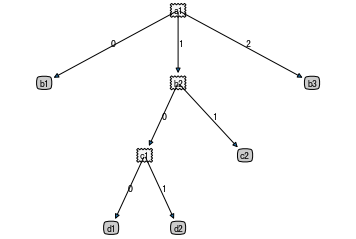

In [104]:
tp = Tp()
myTree = tp.retrieveTree(2)
tp.createPlot(myTree)

## 4.3

In [105]:
import random, math
data3 = pd.read_csv('./data3_full.csv')
print (data3.columns)
data3 = data3.drop(axis=1,columns=['编号','密度', '含糖率'])

Index(['编号', '色泽', '根蒂', '敲声', '纹理', '脐部', '触感', '密度', '含糖率', '好瓜'], dtype='object')


In [285]:
class TreeNode(object):
    def __init__(self, idx, data, val = None):
        self.idx = idx
        self.feature = None
        self.val = val
        self.is_leaf = False
        
        self.posi = len(data[data[data.columns[-1]] == '是'])
        self.nega = len(data[data[data.columns[-1]] == '否'])
        
        self.ch = set()
        self.data = data
    
class DecisionTree(object):
    
    def __init__(self, data):
        self.data = data
        self.nodes = {}
        self.nodes[0] = TreeNode(0, self.data)
        self.tot = 1
        self.n = len(data)
        self.tree = {}
        
    def add_node(self, data, val = None):
        self.nodes[self.tot] = TreeNode(self.tot, data, val)    
        self.tot += 1
        return self.tot - 1

    def Entropy(self, p1):
        if p1 < 1e-6 or p1 > 1.0 - 1e-6:
            return 0
        else:
            return -(p1 * math.log2(p1) + (1 - p1) * math.log2(1 - p1))
    
    def Gain(self, data, feature):
        import math
        p1 = len(data[data[data.columns[-1]] == '是']) / float(len(data))
        gain = self.Entropy(p1)
        groups = data.groupby(feature)
        for dat in groups:
            dat = dat[1]
            p1 = len(dat[dat[dat.columns[-1]] == '是']) / float(len(dat))
            gain -= len(dat) / float(len(data)) * self.Entropy(p1)
        return gain
    
    def sel_feature(self, data): 
        best_feature, max_gain = None, -1e9
        for feature in data.columns[:-1]:
            cur_gain = self.Gain(data, feature)
            if cur_gain > max_gain + 1e-6:
                best_feature, max_gain = feature, cur_gain
        return best_feature
    
    def to_end(self, data):
        if len(data) == 1:
            return True
        if len(data.groupby(data.columns[-1])) == 1:
            return True
        one_class = True
        for feature in data.columns[:-1]:
            if len(data.groupby(feature)) > 1:
                one_class = False
                break
        if one_class:
            return True
        return False
        
    def dfs(self, data, cur = 0, par = -1):
        
        cnt1, cnt0 = self.nodes[cur].posi, self.nodes[cur].nega        
        
        if self.to_end(data):
            self.nodes[cur].is_leaf = True
            if cnt1 * 2.0 > len(data):
                self.nodes[cur].val = "是" + "\n1:{}\n0:{}".format(cnt1, cnt0)
            elif cnt0 * 2.0 > len(data):
                self.nodes[cur].val = "否" + "\n1:{}\n0:{}".format(cnt1, cnt0)
            else:
                self.nodes[cur].val = "是否"[random.randint(0,1)] + "\n1:{}\n0:{}".format(cnt1, cnt0)
            return
        else:
            self.nodes[cur].val = "1:{}\n0:{}".format(cnt1, cnt0)
        
        feature = self.sel_feature(data)
        self.nodes[cur].feature = feature
        
        feature_vals = set(data[feature].values)
        if feature_vals != None:
            for val in feature_vals:
                data_cur = data[data[feature] == val]
                nxt = self.add_node(data_cur)
                self.nodes[cur].ch.add((nxt, val))
                self.dfs(data_cur, nxt, cur)
        
        print (self.nodes[cur].feature, self.nodes[cur].idx, self.nodes[cur].ch)

        
    def get_tree(self, cur = 0,):
        if self.nodes[cur].is_leaf == True:
            return self.nodes[cur].val
        else:
            cur_tree = {}
            for (nxt, val) in self.nodes[cur].ch:
                cur_tree[val] = self.get_tree(nxt)
            return {self.nodes[cur].feature: cur_tree}
    
    def accuracy(self):
        accuracy = 0.0
        for cur in range(self.tot):
            if self.nodes[cur].is_leaf == True:
                if self.nodes[cur].val[0] == '是':
                    accuracy += self.nodes[cur].posi
                else:
                    accuracy += self.nodes[cur].nega
        return accuracy / float(self.n)

In [286]:
dt = DecisionTree(data3)
dt.dfs(dt.data)

触感 5 {(7, '硬滑'), (6, '软粘')}
色泽 3 {(4, '青绿'), (5, '乌黑')}
根蒂 1 {(3, '稍蜷'), (2, '蜷缩'), (8, '硬挺')}
触感 10 {(11, '软粘'), (12, '硬滑')}
纹理 0 {(1, '清晰'), (10, '稍糊'), (9, '模糊')}


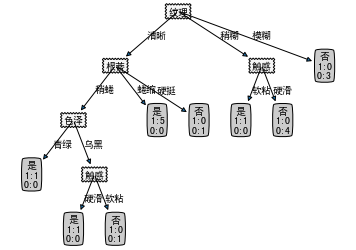

In [287]:
dt.tree = dt.get_tree()
tp = Tp()
tp.createPlot(dt.tree)

In [289]:
print (dt.accuracy())

1.0
